In [3]:
import numpy as np
from NN import get_dataset, get_model, get_shape, set_shape, get_con_mat
from keras.losses import BinaryCrossentropy
import matplotlib.pyplot as plt
import json
from scipy.stats import cauchy

In [23]:
def truncated_cauchy(mean, std, upper=1.0):
    x = cauchy.rvs(mean,std)
    if x > upper:
        x = upper
        return x
    elif x < 0:
        return truncated_cauchy(mean,std)
    else:
        return x

def lehmer_mean(lst):
    if len(lst) == 0:
        return 0
    
    numerator = np.sum(np.power(lst, 2))
    denominator = np.sum(lst)
    return numerator/denominator

def inverse_probability(epsilon, x_0, x_min, x_max):
    y = np.random.random(len(x_min))
    a = (x_max - x_0) / epsilon
    b = (x_min - x_0) / epsilon
    return epsilon * np.tan(y * np.arctan(a) + (1.0 - y) * np.arctan(b)) + x_0

In [24]:
def SoFA(fitFunction, boundaries, initial_population_size = 100, max_iter = 10000, verbose = True, mu_mean=0.5,
         c=0.5, eps_len=300, eps_h_bound=1.2):
    points = [np.random.uniform(boundaries[:, 0], boundaries[:, 1], len(boundaries)) for _ in range(initial_population_size)]
    fitnesses = np.asarray([fitFunction(_) for _ in points])
    fittestValue = np.max(fitnesses)
    worstValue = np.min(fitnesses)
    fittestPoint = points[np.argmax(fitnesses)]
    width = fittestValue - worstValue
    numerator = ((fitnesses-worstValue) / width) ** len(fitnesses)
    denominator = np.sum(numerator)
    probabilities = numerator / denominator
    probabilities = np.absolute(probabilities)
    eps_mean = mu_mean
    counter = 0
    gen_counter = 0
    S_epsilon = []
    loss_history = list()
    while counter < max_iter:
        counter +=1
        epsilon = truncated_cauchy(eps_mean, eps_h_bound)
        index = np.random.choice(len(points), p=probabilities)
        newPoint = inverse_probability(epsilon, points[index], boundaries[:, 0], boundaries[:, 1])
        newFitness = fitFunction(newPoint)
        if newFitness > fitnesses[index]:
            S_epsilon.append(epsilon)
        points.append(newPoint) 
        fitnesses = np.insert(fitnesses,len(fitnesses),newFitness)
        if newFitness > fittestValue :
            fittestPoint = newPoint
            fittestValue = newFitness
            if verbose:
                print("iteration %d : %f mu_mean = %f epsilon = %f" % (counter, -fittestValue, eps_mean , epsilon))
        elif newFitness < worstValue :
            worstValue = newFitness
        loss_history.append(fittestValue)
        width = fittestValue - worstValue
        numerator = ((fitnesses-worstValue) / width) ** len(fitnesses)
        denominator = np.sum(numerator)
        probabilities = numerator / denominator
        probabilities = np.absolute(probabilities)
        if gen_counter == eps_len-1:
            eps_mean = (1-c) * eps_mean + c * lehmer_mean(S_epsilon)
            S_epsilon = []
            gen_counter = 0
        else:
            gen_counter +=1
    return [fittestPoint, fittestValue, loss_history]

In [25]:
X_train, X_test, y_train, y_test = get_dataset()

In [26]:
model = get_model()
model.compile(loss = 'binary_crossentropy', metrics=['accuracy'])

In [27]:
shapes = get_shape(model)

In [28]:
def loss_fun(weights) :
    model.set_weights(set_shape(weights, shapes))
    loss = BinaryCrossentropy()
    predictions =  model(X_train, training=True).numpy().flatten()
    value = loss(y_train, predictions).numpy()
    return -value

In [29]:
limits = [0.522,0.1,0.522,0.1,0.707,0.1]

In [30]:
numbers = []
for shape in shapes:
    numbers.append(np.prod(shape))

In [31]:
max_=np.asarray([])
for i,j in zip(limits,numbers):
    temp = np.asarray([i for _ in range(j)])
    max_ = np.concatenate((max_, temp), axis=None)
min_= max_ * -1
bounds=np.asarray([(i,j) for i,j in zip(min_,max_)])

In [32]:
result=SoFA(loss_fun, bounds, mu_mean=0.5, c=0.7, eps_h_bound=1.0, max_iter = 10000, eps_len=200)
model.set_weights(set_shape(result[0], shapes))
model.evaluate(X_test,y_test)

iteration 65 : 0.556069 mu_mean = 0.500000 epsilon = 0.178351
iteration 102 : 0.551753 mu_mean = 0.500000 epsilon = 1.000000
iteration 109 : 0.536631 mu_mean = 0.500000 epsilon = 0.419459
iteration 113 : 0.534450 mu_mean = 0.500000 epsilon = 0.096926
iteration 292 : 0.529343 mu_mean = 0.500000 epsilon = 0.023757
iteration 349 : 0.525358 mu_mean = 0.500000 epsilon = 0.179685
iteration 365 : 0.524155 mu_mean = 0.500000 epsilon = 0.001812
iteration 474 : 0.513736 mu_mean = 0.595115 epsilon = 1.000000
iteration 581 : 0.501306 mu_mean = 0.595115 epsilon = 0.548498
iteration 600 : 0.482049 mu_mean = 0.595115 epsilon = 0.035361
iteration 648 : 0.478360 mu_mean = 0.595115 epsilon = 0.073049
iteration 1492 : 0.477944 mu_mean = 0.219268 epsilon = 0.006699
iteration 3044 : 0.477499 mu_mean = 0.002062 epsilon = 0.013552
iteration 3404 : 0.472533 mu_mean = 0.010105 epsilon = 0.055857
iteration 3707 : 0.469560 mu_mean = 0.042132 epsilon = 0.004927
iteration 3731 : 0.465517 mu_mean = 0.042132 epsilon

[0.43364372849464417, 0.8044999837875366]

63/63 [==============================] - 0s 2ms/step


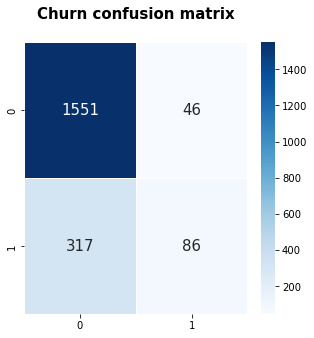

In [16]:
get_con_mat(model, X_test, y_test)

In [19]:
with open("../histories/sofa.json", "r") as f:
    my_list = json.load(f)

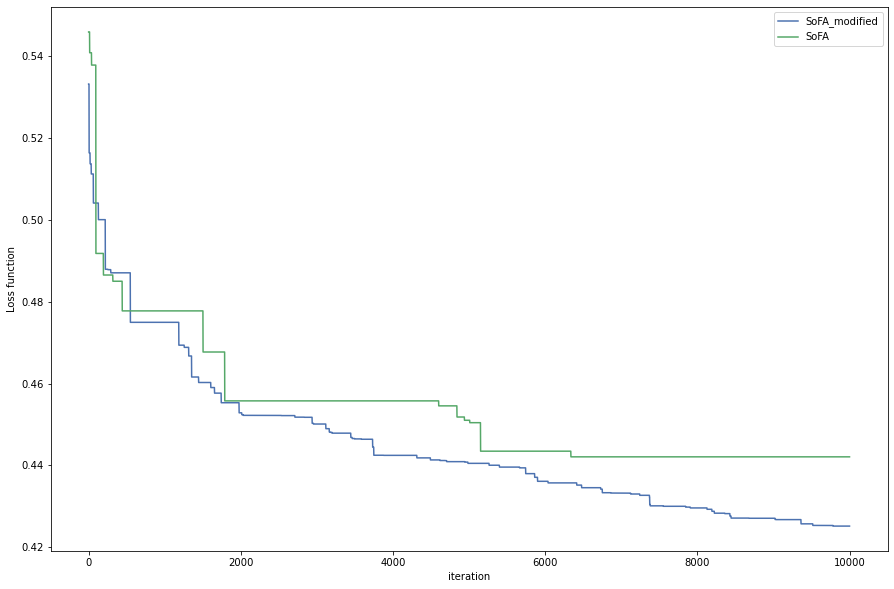

In [22]:
plotting = np.absolute(result[2])
plotting2 = np.absolute(my_list)
plt.figure(figsize=(15,10))
plt.plot(np.arange(10000),plotting, label="SoFA_modified")
plt.plot(np.arange(10000),plotting2, label="SoFA")
plt.xlabel("iteration")
plt.ylabel("Loss function")
plt.savefig('4.png')
plt.legend()
plt.show()